<a href="https://colab.research.google.com/github/OmarMachuca851/Task/blob/main/Deep_Neural_Networks_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scratch Deep Neural Network

In [8]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import matplotlib.pyplot as plt

## Problemas 1-8: Implementación

- problema 1: Clasificación de capas completamente conectadas `class FC:`
- problema 2: Clasificación del método de inicialización `class SimpleInitializer:`
- problema 3: Clasificación de los métodos de optimización `class SGD:`
- problema 4 y 5: Clasificación de funciones de activación  y creación de la clase ReLU
- problema 6: Valores de peso iniciales `class HeInitializer:` y `class XavierInitializer:`
- problema 7: Método de optimización `class AdaGrad:`
- problema 8: Completar la clase `class ScratchDeepNeuralNetworkClassifier:`

In [2]:
# Problem 1: Classifying fully connected layers
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):
        self.X = X
        return X @ self.W + self.B

    def backward(self, dA):
        batch_size = self.X.shape[0]
        self.dW = self.X.T @ dA
        self.dB = np.sum(dA, axis=0)
        dZ = np.dot(dA, self.W.T)

        #Updating weights and biases
        self = self.optimizer.update(self)
        return dZ


# Problem 2: Classifying the initialization method
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)

# Problem 3: Classifying optimization methods
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer


# Problem 4 and 5: Classifying activation function and ReLU class creation
class Tanh:
    def forward(self, A):
        self.A = A
        return self._tanh(A)

    def backward(self, dZ):
        return dZ * (1 - self._tanh(self.A) ** 2)

    def _tanh(self, x):
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))


class Sigmoid:
    def forward(self, A):
        self.A = A
        return 1 / (1 + np.exp(-self.A))

    def backward(self, dZ):
        sig = 1 / (1 + np.exp(-self.A))
        return dZ * sig * (1 - sig)


class ReLU:
    def forward(self, A):
        self.A = A
        return np.maximum(0, A)

    def backward(self, dZ):
        return dZ * (self.A > 0)


class Softmax:
    def forward(self, A):
        exp_A = np.exp(A - np.max(A, axis=1, keepdims=True))
        self.Z = exp_A / np.sum(exp_A, axis=1, keepdims=True)
        return self.Z

    def backward(sefl, Z, Y):
        batch_size = Y.shape[0]
        return (Z - Y)/ batch_size


# Problem 6: Initial value of weight
class HeInitializer:
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(1 / n_nodes1)
        return sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)


class XavierInitializer:
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2 / n_nodes1)
        return sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)


# Problem 7: Optimization method
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.H = {} # Dictionary to store H for each layer

    def update(self, layer):
        # Initializing H i not exists
        if id(layer) not in self.H:
            self.H[id(layer)] = {
                'HW': np.zeros_like(layer.W),
                'HB': np.zeros_like(layer.B)
            }

        HW = self.H[id(layer)]['HW']
        HB = self.H[id(layer)]['HB']

        # Updating HW and HB
        HW += layer.dW ** 2
        HB += layer.dB ** 2

        # Updating weihts and biases
        layer.W -= self.lr * (1 / (np.sqrt(HW) + 1e-7)) * layer.dW
        layer.B -= self.lr * (1 / (np.sqrt(HB) + 1e-7)) * layer.dB

        return layer


# Problem 8: Class completion
class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, layers_config, initializer='simple', optimizer='sgd', sigma=0.01, lr=0.01, epochs=10, batch_size=20, verbose=True):
        self.layers_config = layers_config
        self.sigma = sigma
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

        # Initializing layers
        self._initialize_layers(initializer, optimizer)

        # for learning curve
        self.train_loss = []
        self.val_loss = []

    def _initialize_layers(self, initializer, optimizer):
        # Selecting initializer
        if initializer == 'simple':
            initializer = SimpleInitializer(self.sigma)
        elif initializer == 'xavier':
            initializer = XavierInitializer()
        elif initializer == 'he':
            initializer = HeInitializer()

        # Selecting optimizer
        if optimizer == 'sgd':
            optimizer = SGD(self.lr)
        elif optimizer == 'adagrad':
            optimizer = AdaGrad(self.lr)

        # Creating layers
        self.layers = []
        self.activations = []

        for i, config in enumerate(self.layers_config):
            # Adding FC layer
            n_nodes1 = config['input_dim'] if i == 0 else self.layers_config[i-1]['output_dim']
            n_nodes2 = config['output_dim']
            self.layers.append(FC(n_nodes1, n_nodes2, initializer, optimizer))

            # Adding activation
            if config['activation'] == 'tanh':
                self.activations.append(Tanh())
            elif config['activation'] == 'sigmoid':
                self.activations.append(Sigmoid())
            elif config['activation'] == 'relu':
                self.activations.append(ReLU())
            elif config['activation'] == 'softmax':
                self.activations.append(Softmax())


    def fit(self, X, y, X_val=None, y_val=None):
        for epoch in range(self.epochs):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)

            for mini_X, mini_y in get_mini_batch:
                # Forward propagation
                A = mini_X
                for layer, activation in zip(self.layers, self.activations):
                    A = layer.forward(A)
                    Z = activation.forward(A)
                    A = Z
                # backward propagation
                dA = self.activations[-1].backward(Z, mini_y)
                for i in reversed(range(len(self.layers))):
                    dZ = self.layers[i].backward(dA)
                    if i > 0:
                        dA = self.activations[i-1].backward(dZ)

            # Calculating loss
            train_loss = self._calc_loss(X, y)
            self.train_loss.append(train_loss)

            if X_val is not None and y_val is not None:
                val_loss = self._calc_loss(X_val, y_val)
                self.val_loss.append(val_loss)

            if self.verbose:
                print(f'Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}',
                    f'Val Loss: {val_loss:.4f}' if X_val is not None and y_val is not None else '')

    def _calc_loss(self, X, y):
        # Forward propagation
        A = X
        for layer, activation in zip(self.layers, self.activations):
            A = layer.forward(A)
            Z = activation.forward(A)
            A = Z

        # Calculating loss
        delta = 1e-7
        return -np.sum(y * np.log(Z + delta)) / y.shape[0]

    def predict(self, X):
        # Forward propagation
        A = X
        for layer, activation in zip(self.layers, self.activations):
            A = layer.forward(A)
            Z = activation.forward(A)
            A = Z

        return np.argmax(Z, axis=1)


class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = int(np.ceil(X.shape[0]/self.batch_size))

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## Problema 9: aprendizaje y estimación

In [7]:
def load_and_preprocess_data():
    # Loading MNIST data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    #X_train, y_train, X_test, y_test = X_train[:6000], y_train[:6000], X_test[:1000], y_test[:1000]
    # Preprocessimg
    X_train = X_train.reshape(-1, 784).astype(np.float32) / 255
    X_test = X_test.reshape(-1, 784).astype(np.float32) / 255

    # One-hot encode labels
    from packaging.version import Version
    import sklearn

    if Version(sklearn.__version__) >= Version('1.2'):
        enc  = OneHotEncoder(sparse_output=False)
    else:
        enc = OneHotEncoder(sparse=False)

    y_train_one_hot = enc.fit_transform(y_train.reshape(-1, 1))
    y_test_one_hot = enc.transform(y_test.reshape(-1, 1))

    # Splitting into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    #y_val_labels = np.argmax(y_val, axis=1)
    accuracy = np.mean(y_pred == y_val)
    print(f'Validation Accuracy: {accuracy:.4f}')

    # Plotting learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(model.train_loss, label='Train Loss')
    if model.val_loss:
        plt.plot(model.val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()

def visualize_misclassications(model, X_val, y_val, num=49):
    y_pred = model.predict(X_val)
    #y_val_labels = np.argmax(y_val, axis=1)

    true_false = y_pred == y_val
    false_list = np.where(true_false == False)[0].astype(int)

    if false_list.shape[0] < num:
        num = false_list.shape[0]

    fig = plt.figure(figsize=(7, 7))
    fig.subplots_adjust(left=0, right=0.8, bottom=0, top=0.8, hspace=1, wspace=0.5)

    for i in range(num):
        ax = fig.add_subplot(7, 7, i+1, xticks=[], yticks=[])
        ax.set_title(f'{y_pred[false_list[i]]} / {y_val[false_list[i]]}')
        ax.imshow(X_val.reshape(-1, 28, 28)[false_list[i]], cmap='gray')

    plt.show()

# Loading and preprocesing data
X_train, y_train, X_val, y_val, X_test, y_test = load_and_preprocess_data()

# Example configurations for problem 9
config1 =[
    {'input_dim': 784, 'output_dim': 400, 'activation': 'tanh'},
    {'input_dim': 400, 'output_dim': 200, 'activation': 'tanh'},
    {'input_dim': 200, 'output_dim': 10, 'activation': 'softmax'}
]

config2 =[
    {'input_dim': 784, 'output_dim': 400, 'activation': 'relu'},
    {'input_dim': 400, 'output_dim': 200, 'activation': 'relu'},
    {'input_dim': 200, 'output_dim': 10, 'activation': 'softmax'}
]

config3 =[
    {'input_dim': 784, 'output_dim': 512, 'activation': 'relu'},
    {'input_dim': 512, 'output_dim': 256, 'activation': 'relu'},
    {'input_dim': 256, 'output_dim': 128, 'activation': 'relu'},
    {'input_dim': 128, 'output_dim': 10, 'activation': 'softmax'}
]

### Model 1: Activación Tanh con inicializador simple y SGD

Epoch 1/10, Train Loss: 0.6774 Val Loss: 0.6739
Epoch 2/10, Train Loss: 0.4127 Val Loss: 0.4132
Epoch 3/10, Train Loss: 0.3485 Val Loss: 0.3510
Epoch 4/10, Train Loss: 0.3158 Val Loss: 0.3199
Epoch 5/10, Train Loss: 0.2898 Val Loss: 0.2957
Epoch 6/10, Train Loss: 0.2671 Val Loss: 0.2747
Epoch 7/10, Train Loss: 0.2475 Val Loss: 0.2568
Epoch 8/10, Train Loss: 0.2299 Val Loss: 0.2410
Epoch 9/10, Train Loss: 0.2139 Val Loss: 0.2267
Epoch 10/10, Train Loss: 0.1991 Val Loss: 0.2135
Validation Accuracy: 0.9401


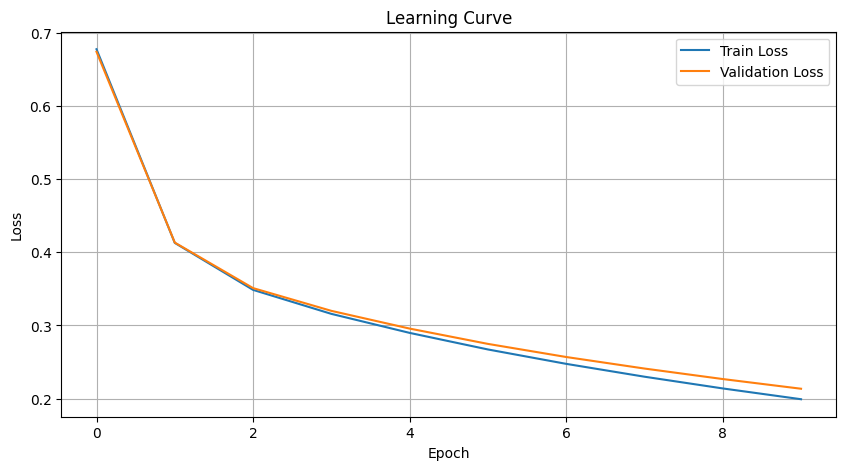

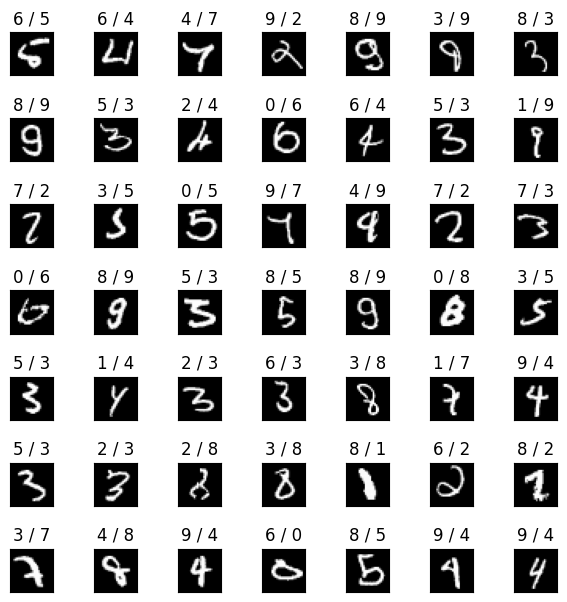

In [4]:
model1 = ScratchDeepNeuralNetworkClassifier(
    layers_config=config1,
    initializer='simple',
    optimizer='sgd',
    sigma=0.01,
    lr=0.01,
    epochs=10,
    batch_size=20
)
model1.fit(X_train, y_train, X_val, y_val)
evaluate_model(model1, X_test, y_test)
visualize_misclassications(model1, X_test, y_test)

### Modelo 2: Activación ReLU con inicializador He y AdaGrad

Epoch 1/10, Train Loss: 0.0933 Val Loss: 0.1138
Epoch 2/10, Train Loss: 0.0615 Val Loss: 0.0911
Epoch 3/10, Train Loss: 0.0453 Val Loss: 0.0814
Epoch 4/10, Train Loss: 0.0352 Val Loss: 0.0765
Epoch 5/10, Train Loss: 0.0278 Val Loss: 0.0732
Epoch 6/10, Train Loss: 0.0226 Val Loss: 0.0717
Epoch 7/10, Train Loss: 0.0187 Val Loss: 0.0708
Epoch 8/10, Train Loss: 0.0155 Val Loss: 0.0701
Epoch 9/10, Train Loss: 0.0129 Val Loss: 0.0698
Epoch 10/10, Train Loss: 0.0110 Val Loss: 0.0699
Validation Accuracy: 0.9796


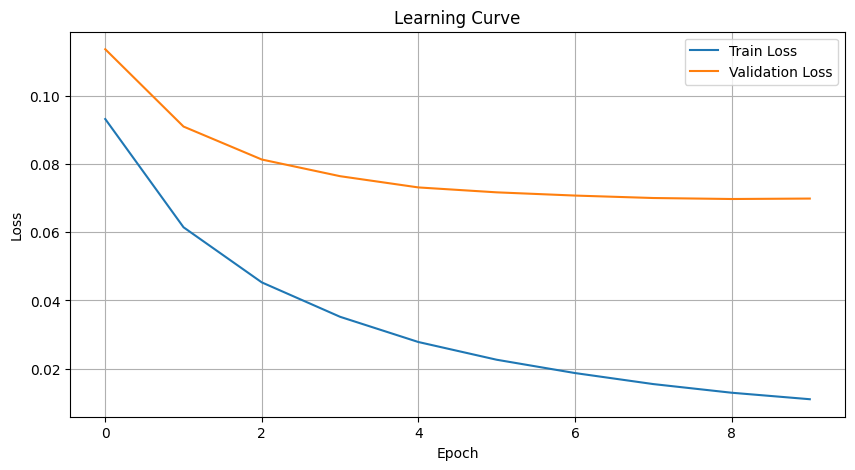

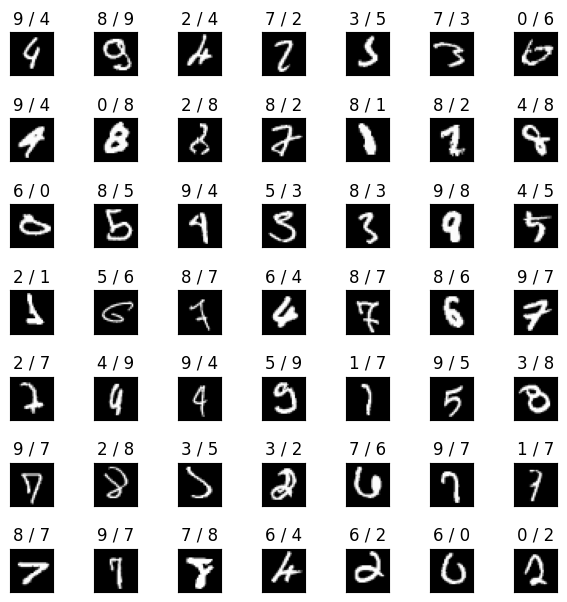

In [5]:
model1 = ScratchDeepNeuralNetworkClassifier(
    layers_config=config2,
    initializer='he',
    optimizer='adagrad',
    sigma=0.01,
    lr=0.01,
    epochs=10,
    batch_size=20
)
model1.fit(X_train, y_train, X_val, y_val)
evaluate_model(model1, X_test, y_test)
visualize_misclassications(model1, X_test, y_test)

### Modelo 3: Red mas profunda con ReLU e inicializador He

Epoch 1/10, Train Loss: 0.0820 Val Loss: 0.1058
Epoch 2/10, Train Loss: 0.0486 Val Loss: 0.0836
Epoch 3/10, Train Loss: 0.0317 Val Loss: 0.0751
Epoch 4/10, Train Loss: 0.0225 Val Loss: 0.0725
Epoch 5/10, Train Loss: 0.0158 Val Loss: 0.0718
Epoch 6/10, Train Loss: 0.0113 Val Loss: 0.0728
Epoch 7/10, Train Loss: 0.0080 Val Loss: 0.0744
Epoch 8/10, Train Loss: 0.0063 Val Loss: 0.0772
Epoch 9/10, Train Loss: 0.0053 Val Loss: 0.0798
Epoch 10/10, Train Loss: 0.0041 Val Loss: 0.0811
Validation Accuracy: 0.9802


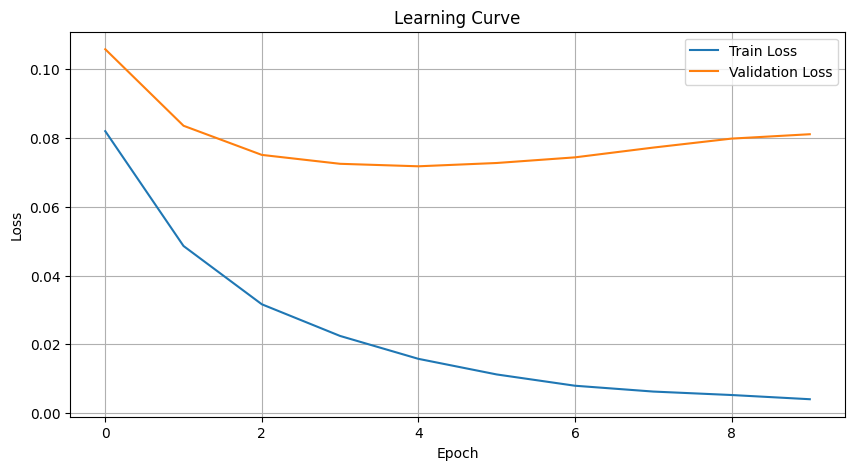

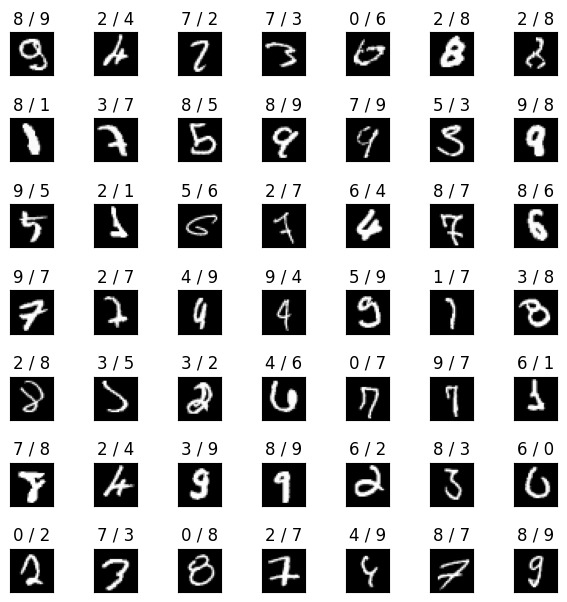

In [6]:
model1 = ScratchDeepNeuralNetworkClassifier(
    layers_config=config3,
    initializer='he',
    optimizer='adagrad',
    sigma=0.01,
    lr=0.01,
    epochs=10,
    batch_size=20
)
model1.fit(X_train, y_train, X_val, y_val)
evaluate_model(model1, X_test, y_test)
visualize_misclassications(model1, X_test, y_test)